# Mushroom classification with CNN

## $\textcolor{blue}{\text{Creating dataloader}}$

### 1.1 loadData.py
Using the images provided in the folder, prepare your data using pytorch data loader.

In [1]:
from pathlib import Path
import sys

# Resolve project root dynamically
project_root = Path.cwd().parent

# Add src to path
sys.path.append(str(project_root / "src"))

# Dataset directory (local only, not in GitHub)
DATA_DIR = project_root / "trainval"


In [2]:
# Load liberary
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#import torch to build deep learning models and to train them
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#import torchvision for loading and working with image data
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

#import tqdm to measure progress during training
import tqdm

In [3]:
from loadData import loadData
from model import Classifier
print("Import OK")

Import OK


In [4]:
train_dataset, val_dataset, train_dataloader, val_dataloader = loadData(filedir=DATA_DIR)

In [5]:
 print(f'Size of train dataset: {len(train_dataset)}')
 print(f'Size of val dataset: {len(val_dataset)}')

Size of train dataset: 900
Size of val dataset: 100


### 1.2 Image examples

Follow the layout of the figure provided

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7851416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5075778..1.21346].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.4874561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.82].
Clipping

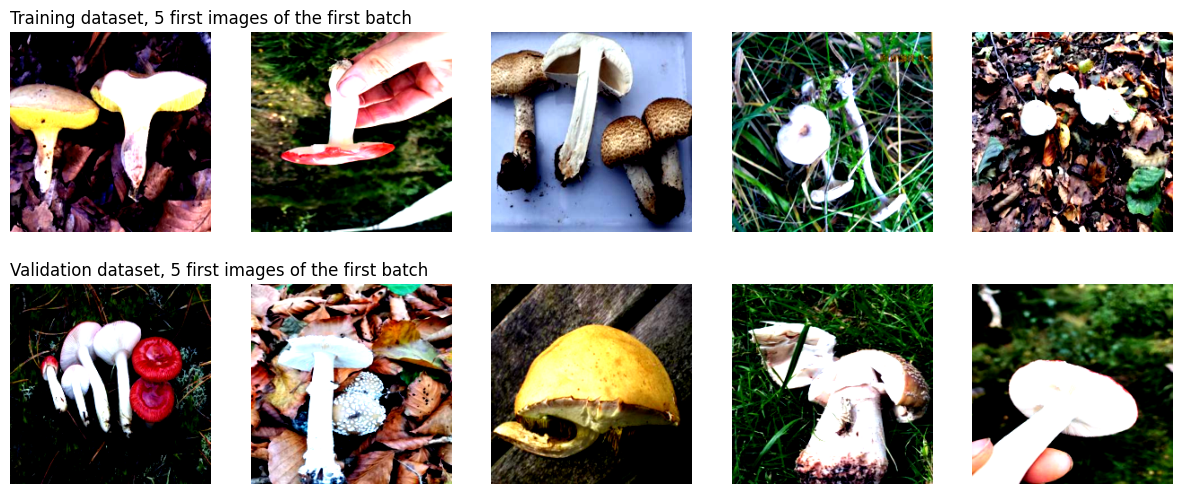

In [6]:
#Inspecting the Data
fig, ax = plt.subplots(2, 5,figsize=(15,6))
for idx in range(5):
    train_image = train_dataset[idx][0].numpy().transpose(1,2,0)
    train_image = (train_image * 0.5) + 0.5
    ax[0, idx].imshow(train_image)

    val_image = val_dataset[idx][0].numpy().transpose(1,2,0)
    val_image = (val_image * 0.5) + 0.5
    ax[1, idx].imshow(val_image)

    ax[0, idx].set_axis_off()
    ax[1, idx].set_axis_off()

ax[0,0].set_title("Training dataset, 5 first images of the first batch",fontsize=12, loc='left')

ax[1,0].set_title("Validation dataset, 5 first images of the first batch",fontsize=12, loc='left')
plt.show()

## $\textcolor{blue}{\text{Model with best performance}}$

### 2.1 Import your code and train your model

Import your model and train it!

In [7]:
from model import Classifier

In [8]:
imagenet_means = (0.485, 0.456, 0.406)
imagenet_stds = (0.229, 0.224, 0.225)
transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_means, imagenet_stds)])

trainval_dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=transform)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Hyperparameters

total_epochs = 15
batch_size = 32

label_smoothing=0.1

lr = 0.005
momentum = 0.9
weight_decay=0.0001


#Initialise the model.
model = Classifier(freeze_backbone=True).to(device)

# Weight (expecially for poisonous )

train_targets = trainval_dataset.targets
class_sample_count = np.bincount(train_targets)
class_weights = 1. / class_sample_count

for i in range(5, 10):
    class_weights[i] *= 1.5

weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define a loss function
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=label_smoothing)

# Initialise the SGD optimizer.
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

In [10]:
#For n epochs
total_train_loss, total_val_loss = [], []
total_train_acc, total_val_acc = [], []
best_acc = 0
for epoch in range(total_epochs):

    #Put the model in "train" mode
    model.train()

    #Training loop: For all batches in the training dataset
    train_loss = []
    correct = 0
    total = 0

    for i, data in tqdm.tqdm(enumerate(train_dataloader, 0), total =len(train_dataloader), desc = f'Epoch {epoch+1} - training phase'):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += [loss.cpu().item()]
        predicted = torch.argmax(outputs, axis = 1)
        correct += torch.sum(predicted == labels).cpu().item()
        total += len(labels)

    mean_train_loss = np.mean(train_loss)
    train_accuracy = correct/total
    print(f"Training {epoch+1}: loss={mean_train_loss:.3f} acc={train_accuracy:.3f}")

    total_train_loss += [mean_train_loss]
    total_train_acc += [train_accuracy]

    #Put the model in "eval" mode
    model.eval()

    #Validation loop: For all batches in the validation dataset
    with torch.no_grad(): # not build the computation graph for backpropagation, and thus, no gradients will be computed or stored for the tensors involved in those operations.
        val_loss, val_correct, val_total = 0.0, 0.0, 0.0
        for i, data in tqdm.tqdm(enumerate(val_dataloader, 0), total =len(val_dataloader), desc = f'Epoch {epoch+1} - validation phase'):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            predicted = torch.argmax(outputs, axis = 1)

            loss = criterion(outputs, labels)
            val_loss += loss.cpu().item() * inputs.size(0)

            val_correct += torch.sum(predicted == labels).cpu().item()
            val_total += inputs.size(0)

        mean_val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total
        print(f"Validation {epoch+1}: loss={mean_val_loss:.3f}acc={val_accuracy:.3f}")
        if val_accuracy > best_acc:
            torch.save(model.state_dict(), "resnet_best.pth")
            best_acc = val_accuracy
        total_val_loss.append(mean_val_loss)
        total_val_acc.append(val_accuracy)

Epoch 1 - training phase: 100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


Training 1: loss=2.170 acc=0.304


Epoch 1 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Validation 1: loss=2.144acc=0.490


Epoch 2 - training phase: 100%|██████████| 113/113 [00:14<00:00,  7.55it/s]


Training 2: loss=1.829 acc=0.476


Epoch 2 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.46it/s]


Validation 2: loss=1.914acc=0.590


Epoch 3 - training phase: 100%|██████████| 113/113 [00:15<00:00,  7.40it/s]


Training 3: loss=1.736 acc=0.571


Epoch 3 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.42it/s]


Validation 3: loss=1.928acc=0.550


Epoch 4 - training phase: 100%|██████████| 113/113 [00:15<00:00,  7.31it/s]


Training 4: loss=1.604 acc=0.574


Epoch 4 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.37it/s]


Validation 4: loss=1.603acc=0.580


Epoch 5 - training phase: 100%|██████████| 113/113 [00:15<00:00,  7.28it/s]


Training 5: loss=1.552 acc=0.577


Epoch 5 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.05it/s]


Validation 5: loss=1.723acc=0.590


Epoch 6 - training phase: 100%|██████████| 113/113 [00:15<00:00,  7.28it/s]


Training 6: loss=1.698 acc=0.564


Epoch 6 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.07it/s]


Validation 6: loss=1.795acc=0.570


Epoch 7 - training phase: 100%|██████████| 113/113 [00:15<00:00,  7.22it/s]


Training 7: loss=1.565 acc=0.604


Epoch 7 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


Validation 7: loss=1.670acc=0.550


Epoch 8 - training phase: 100%|██████████| 113/113 [00:15<00:00,  7.31it/s]


Training 8: loss=1.606 acc=0.576


Epoch 8 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.24it/s]


Validation 8: loss=1.859acc=0.540


Epoch 9 - training phase: 100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


Training 9: loss=1.575 acc=0.614


Epoch 9 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Validation 9: loss=1.837acc=0.550


Epoch 10 - training phase: 100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


Training 10: loss=1.523 acc=0.636


Epoch 10 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


Validation 10: loss=2.069acc=0.580


Epoch 11 - training phase: 100%|██████████| 113/113 [00:15<00:00,  7.47it/s]


Training 11: loss=1.531 acc=0.629


Epoch 11 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


Validation 11: loss=1.950acc=0.550


Epoch 12 - training phase: 100%|██████████| 113/113 [00:14<00:00,  7.56it/s]


Training 12: loss=1.396 acc=0.666


Epoch 12 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.24it/s]


Validation 12: loss=1.995acc=0.580


Epoch 13 - training phase: 100%|██████████| 113/113 [00:15<00:00,  7.40it/s]


Training 13: loss=1.616 acc=0.614


Epoch 13 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.01it/s]


Validation 13: loss=2.069acc=0.540


Epoch 14 - training phase: 100%|██████████| 113/113 [00:14<00:00,  7.54it/s]


Training 14: loss=1.569 acc=0.624


Epoch 14 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Validation 14: loss=1.814acc=0.580


Epoch 15 - training phase: 100%|██████████| 113/113 [00:15<00:00,  7.39it/s]


Training 15: loss=1.527 acc=0.633


Epoch 15 - validation phase: 100%|██████████| 13/13 [00:01<00:00,  8.54it/s]

Validation 15: loss=2.048acc=0.570


In [11]:
#Final Training on Full Dataset

model = Classifier(freeze_backbone= True).to(device)

checkpoint = torch.load("resnet_best.pth", map_location=device)
model.load_state_dict(checkpoint)
print("Loaded previous best weights!")

trainval_dataloader = torch.utils.data.DataLoader(trainval_dataset, batch_size=8, shuffle=True)

epochs = 10
batch_size = 8

label_smoothing=0.1

lr = 0.001
momentum = 0.9
weight_decay=0.0001


# Define a loss function
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=label_smoothing)

# Initialise the SGD optimizer.
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in trainval_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainval_dataset)
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    torch.save(model.state_dict(), "final_renet.pth")
print("✅ Final model saved as final_renet.pth")

Loaded previous best weights!
Epoch 1/10, Loss: 1.4082, Acc: 0.6410
Epoch 2/10, Loss: 1.3457, Acc: 0.6500
Epoch 3/10, Loss: 1.2827, Acc: 0.6740
Epoch 4/10, Loss: 1.2425, Acc: 0.6890
Epoch 5/10, Loss: 1.2096, Acc: 0.7050
Epoch 6/10, Loss: 1.2127, Acc: 0.7040
Epoch 7/10, Loss: 1.1885, Acc: 0.7260
Epoch 8/10, Loss: 1.1600, Acc: 0.7330
Epoch 9/10, Loss: 1.1053, Acc: 0.7670
Epoch 10/10, Loss: 1.2118, Acc: 0.6980
✅ Final model saved as final_renet.pth


### 2.2 plot the loss

Show the loss vs epoch for the training and validation, follow the layout of the figure provided in the brief

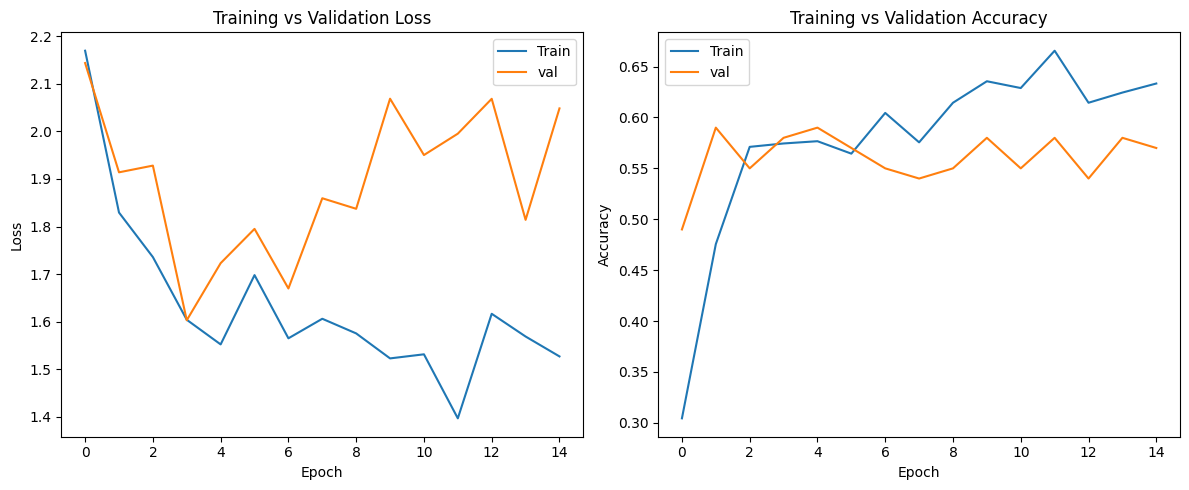

In [12]:
# Training and Validation Loss / Accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(total_train_loss, label = 'Train')
ax1.plot(total_val_loss, label = 'val')
ax1.set_title('Training vs Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()


ax2.plot(total_train_acc, label = 'Train')
ax2.plot(total_val_acc, label = 'val')
ax2.set_title('Training vs Validation Accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

### 2.3 Compute the performance

Show the ROC, confusion matrix, and other appropriate metrics

In [13]:
model.load_state_dict(torch.load('resnet_best.pth'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
trainvalloader = torch.utils.data.DataLoader(trainval_dataset, batch_size=32, shuffle=False)

gts, probs = [], []
with torch.no_grad():
    model.eval()
    for i, data in tqdm.tqdm(enumerate(trainvalloader), total=len(trainvalloader),desc="Evaluating"):

        inputs, label = data


        inputs = inputs.to(device)


        outputs = model(inputs)
        probability = F.softmax(outputs, dim=-1)


        gts.append(label)
        probs.append(probability.cpu().numpy())

gts = np.concatenate(gts).astype(np.int32)
probs = np.vstack(probs).astype(np.float32)

poisonous_labels = [idx for idx, name in enumerate(val_dataset.dataset.classes) if'poisonous' in name]

gts_poisonous = np.isin(gts,poisonous_labels)
probs_poisonous = probs[:, poisonous_labels].sum(axis=1)


Evaluating: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]


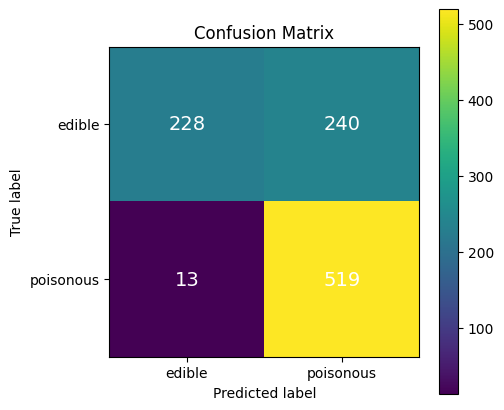

precision=0.68, recall=0.98, specificity=0.49, f-score=0.80


In [14]:
# Confusion Matrix

preds_poisonous = probs_poisonous > 0.3
tp = np.logical_and(preds_poisonous, gts_poisonous).sum()
fp = np.logical_and(preds_poisonous, ~gts_poisonous).sum()
tn = np.logical_and(~preds_poisonous, ~gts_poisonous).sum()
fn = np.logical_and(~preds_poisonous, gts_poisonous).sum()
cm_counts = np.array([[tn, fp], [fn, tp]]).astype(np.int32)
labels = ['edible','poisonous']
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm_counts, cmap='viridis')

# Add text annotations
for i in range(cm_counts.shape[0]):
    for j in range(cm_counts.shape[1]):
        ax.text(j, i, str(cm_counts[i, j]),
            ha='center', va='center', color='white', fontsize=14)

# Set ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

# Optional: colorbar
plt.colorbar(im, ax=ax)
plt.show()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
spec = tn/(tn+fp)
fscore = (2 * (prec * rec)) / (prec + rec)
print(f"precision={prec:.2f}, recall={rec:.2f}, specificity={spec:.2f}, f-score={fscore:.2f}")

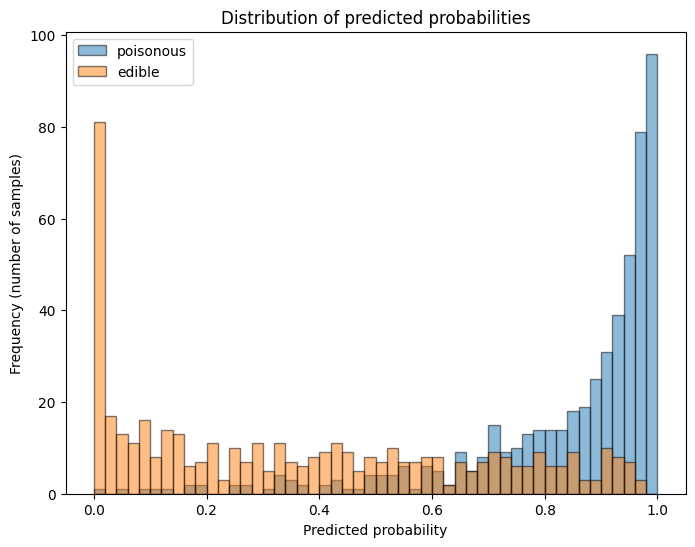

In [15]:
#The distribution of predicted probabilities

num_bins = 50
poisonous_counts, poisonous_bin_edges = np.histogram(probs_poisonous[gts_poisonous],bins=num_bins, range=(0, 1))
edible_counts, edible_bin_edges = np.histogram(probs_poisonous[~gts_poisonous],bins=num_bins, range=(0, 1))

# Plot histogram using matplotlib
plt.figure(figsize=(8, 6))
plt.bar(poisonous_bin_edges[:-1], poisonous_counts, width=poisonous_bin_edges[1]- poisonous_bin_edges[0], edgecolor='black', align='edge', label='poisonous',alpha=0.5)
plt.bar(edible_bin_edges[:-1], edible_counts, width=edible_bin_edges[1]- edible_bin_edges[0], edgecolor='black', align='edge', label='edible',alpha=0.5)

plt.xlabel('Predicted probability')
plt.ylabel('Frequency (number of samples)')
plt.title('Distribution of predicted probabilities')
plt.xticks(np.linspace(0, 1, 6))
plt.legend()
plt.show()

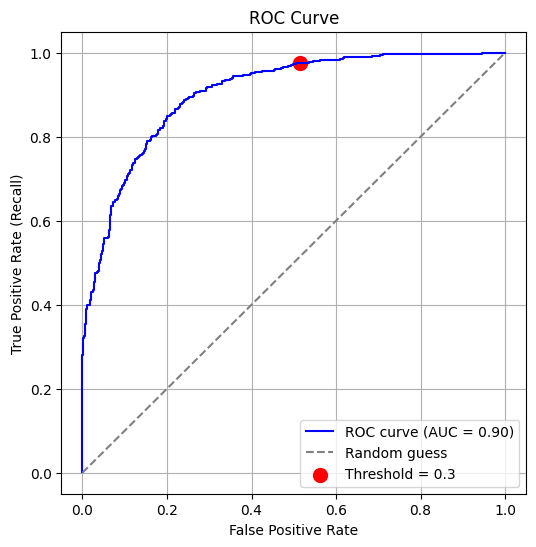

In [16]:
# ROC Curve
desc_order = np.argsort(-probs_poisonous)
y_true_sorted = gts_poisonous[desc_order]
y_scores_sorted = probs_poisonous[desc_order]

# Initialize counts
TP, FP = 0, 0,
P, N = np.sum(gts_poisonous == 1), np.sum(gts_poisonous == 0)

tpr_list = []
fpr_list = []

for label in y_true_sorted:
    if label == 1:
        TP += 1
    else:
        FP += 1
    tpr_list.append(TP / P)
    fpr_list.append(FP / N)

# Convert to numpy arrays
tpr = np.array(tpr_list)
fpr = np.array(fpr_list)
auc = np.trapz(tpr, fpr)

decision_threshold = 0.3
idx = (np.abs(y_scores_sorted - decision_threshold)).argmin()
highlight_fpr, highlight_tpr = fpr[idx], tpr[idx]


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')

plt.scatter(highlight_fpr, highlight_tpr, color='red', s=100,label=f'Threshold = {decision_threshold}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()